<a href="https://colab.research.google.com/github/joyceee916/ATMS597-Project-6-Group-C/blob/master/Project6_Joyce_Katrina.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf 
from tensorflow import keras 
from keras.models import Sequential 
from keras.layers import Dense
from keras.callbacks import EarlyStopping
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import seaborn as sns; sns.set()

In [2]:
df = pd.read_csv('/content/drive/My Drive/ATMS 597/Project6/openFEMA_claims20190831.csv')

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (0,11,15,22,23,31,32,37) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [0]:
# Keep only potentially useful columns 
df = df[['basefloodelevation', 'policycount', 'elevatedbuildingindicator', 'elevationdifference', 'floodzone', 'originalconstructiondate', 'originalnbdate', 'amountpaidonbuildingclaim', 'amountpaidoncontentsclaim', 'amountpaidonincreasedcostofcomplianceclaim', 'postfirmconstructionindicator', 'ratemethod', 'state', 'totalbuildinginsurancecoverage', 'totalcontentsinsurancecoverage', 'yearofloss', 'dateofloss']]

# Convert negative values for claims to their positive values (because a negative value means that the check issued to the policyholder wasn't cashed in, and needs to be reissued)
df.amountpaidonbuildingclaim = df.amountpaidonbuildingclaim.abs()
df.amountpaidoncontentsclaim = df.amountpaidoncontentsclaim.abs()
df.amountpaidonincreasedcostofcomplianceclaim = df.amountpaidonincreasedcostofcomplianceclaim.abs()

# Replace NaN values for claims with 0
df.amountpaidonbuildingclaim.fillna(0, inplace=True)
df.amountpaidoncontentsclaim.fillna(0, inplace=True)
df.amountpaidonincreasedcostofcomplianceclaim.fillna(0, inplace=True)

# Create a new column that is the sum of all of the amounts paid 
df['totalamountpaid'] = df['amountpaidonbuildingclaim'] + df['amountpaidoncontentsclaim'] + df['amountpaidonincreasedcostofcomplianceclaim']

# Delete intermediate columns 
df.drop(columns=['amountpaidonbuildingclaim', 'amountpaidoncontentsclaim', 'amountpaidonincreasedcostofcomplianceclaim'], inplace=True)

# Replace elevation difference values that are 999.0 with NaN 
df.replace({'elevationdifference': {999.0: np.nan}}, inplace=True)

In [4]:
df

,basefloodelevation,policycount,elevatedbuildingindicator,elevationdifference,floodzone,originalconstructiondate,originalnbdate,postfirmconstructionindicator,ratemethod,state,totalbuildinginsurancecoverage,totalcontentsinsurancecoverage,yearofloss,dateofloss,totalamountpaid
0,NaN,1.0,N,NaN,X,1963-01-01,1997-01-11,N,7,CA,200000.0,50000.0,1998,1998-02-07,0.00
1,NaN,1.0,N,NaN,X,1967-07-01,1990-07-12,N,7,LA,100000.0,40000.0,2005,2005-08-29,0.00
2,NaN,1.0,N,NaN,X,1972-01-01,1997-07-24,N,1,FL,100000.0,50000.0,1998,1998-09-28,10533.21
3,NaN,1.0,N,NaN,X,1960-01-01,1993-10-01,N,7,SC,100000.0,25000.0,1994,1994-10-07,2906.00
4,NaN,1.0,N,NaN,X,1988-01-01,1996-01-11,Y,7,FL,100000.0,25000.0,1996,1996-03-11,5420.53
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2432883,9.0,1.0,N,1.0,AHB,1985-01-01,2003-12-06,Y,1,FL,131000.0,45000.0,2005,2005-08-26,6123.27
2432884,9.0,1.0,N,1.0,AHB,1990-01-01,2004-02-04,Y,1,FL,153300.0,76700.0,2005,2005-08-25,5010.88
2432885,10.0,1.0,N,-1.0,AE,1959-01-01,2004-07-16,N,1,FL,245000.0,100000.0,2005,2005-06-20,8335.35
2432886,NaN,1.0,N,NaN,AE,1959-01-01,2004-07-16,N,1,FL,245000.0,100000.0,2005,2005-08-25,2396.44


In [0]:
df['originalconstructiondate'] = pd.to_datetime(df['originalconstructiondate'], errors='coerce')
df['originalnbdate'] = pd.to_datetime(df['originalnbdate'])
df['dateofloss'] = pd.to_datetime(df['dateofloss'])

In [0]:
df.replace({'elevatedbuildingindicator': {'Y': 1, 'N': 0}}, inplace=True)
df.replace({'postfirmconstructionindicator': {'Y': 1, 'N': 0}}, inplace=True)
df.replace({'ratemethod': {'B': 10, 'A': 11, 'Q':12, 'P':13, 'W':14, 'S':15, 'F':16, 'E': 17, 9.0:9, 8.0:8, 5.0:5, 6.0:6, 
                           'G':18, 'T':19, '7':7, '1':1, '2':2, '4':4, '3':3, '8':8, '6':6, '9':9, '5':5}}, inplace=True)

In [8]:
df.totalamountpaid.max()

10000000.0

In [0]:
# Hurricane Katrina was from August 23, 2005 to August 31, 2005 
#katrina = df[(df['dateofloss'] > '2005-08-22') & (df['dateofloss'] < '2005-09-01')]

In [0]:
features = ['basefloodelevation', 'policycount', 'elevatedbuildingindicator', 'elevationdifference', 
            'postfirmconstructionindicator', 'ratemethod', 'totalbuildinginsurancecoverage', 
            'totalcontentsinsurancecoverage', 'yearofloss']
features = ['basefloodelevation', 'policycount', 'totalbuildinginsurancecoverage', 'totalcontentsinsurancecoverage', 'postfirmconstructionindicator', 'yearofloss', 'ratemethod']
target = ['totalamountpaid']    

df = df[features+target].dropna()
x_train, x_test, y_train, y_test = train_test_split(df[features], df[target], test_size=0.2)

In [11]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(384314, 7)
(384314, 1)
(96079, 7)
(96079, 1)


In [0]:
model = Sequential()

n_cols = x_train.shape[1]

model.add(Dense(10, activation='relu', input_shape=(n_cols,)))
model.add(Dense(10, activation='relu'))
model.add(Dense(200, activation='relu'))
model.add(Dense(1))

In [0]:
model.compile(optimizer='adam', loss='mean_squared_error')

In [14]:
early_stopping_monitor = EarlyStopping(patience=3)

model.fit(x_train, y_train, epochs=10, validation_split=0.2, callbacks=[early_stopping_monitor])

Train on 307451 samples, validate on 76863 samples
Epoch 1/10
307451/307451 [==============================] - 13s 43us/step - loss: 13137277161.8889 - val_loss: 6854689672.2449
Epoch 2/10
307451/307451 [==============================] - 13s 43us/step - loss: 7107641462.9761 - val_loss: 6677285447.8411
Epoch 3/10
307451/307451 [==============================] - 14s 45us/step - loss: 6949479784.7386 - val_loss: 6576212452.1229
Epoch 4/10
307451/307451 [==============================] - 13s 44us/step - loss: 6868542595.6291 - val_loss: 6466235221.6731
Epoch 5/10
307451/307451 [==============================] - 13s 43us/step - loss: 6880568577.9409 - val_loss: 6548421241.3205
Epoch 6/10
307451/307451 [==============================] - 13s 43us/step - loss: 9888809977.0607 - val_loss: 6486554618.3247
Epoch 7/10
307451/307451 [==============================] - 13s 44us/step - loss: 6792722371.3412 - val_loss: 6485226377.6304


In [20]:
import math 
from math import sqrt
y_model = model.predict(x_train)
y_predict = model.predict(x_test)

rmse_train = sqrt(mean_squared_error(y_train, y_model))
rmse_test = sqrt(mean_squared_error(y_test, y_predict))
print(rmse_train, rmse_test)


81807.73176654457 83806.65298529115


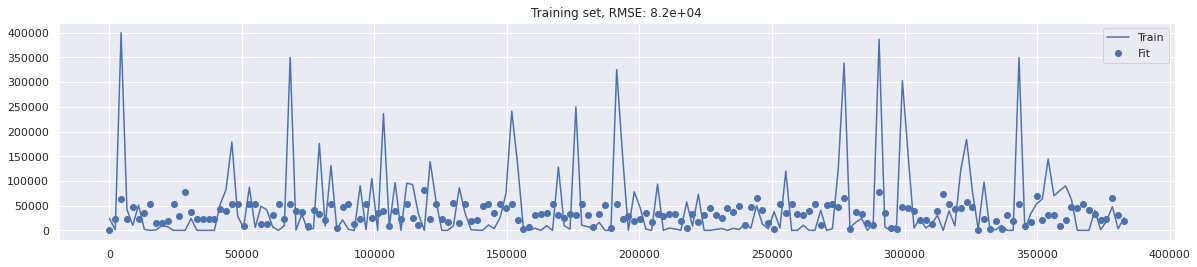

In [36]:
import seaborn as sns
plt.figure(figsize = (20,4))
plt.plot(np.arange(len(y_train))[::2200], y_train[::2200], label='Train')
plt.scatter(np.arange(len(y_model))[::2200], y_model[::2200], label='Fit')
plt.legend()
plt.title('Training set, RMSE: {0:.1e}'.format(rmse_train))
plt.show()

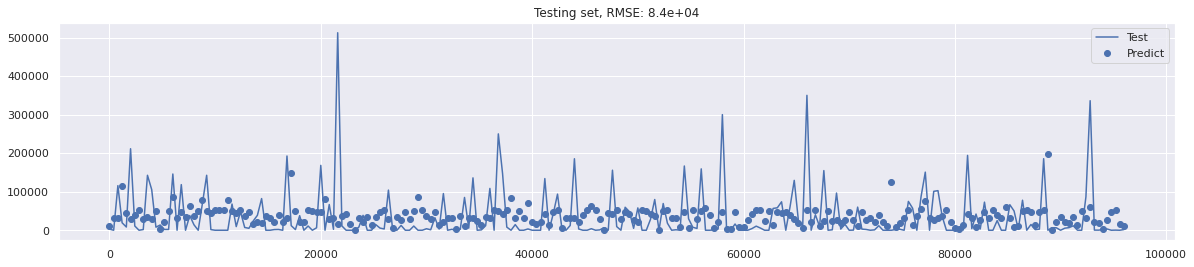

In [31]:
plt.figure(figsize = (20,4))
plt.plot(np.arange(len(y_test))[::400], y_test[::400], label='Test')
plt.scatter(np.arange(len(y_predict))[::400], y_predict[::400], label='Predict')
plt.legend()
plt.title('Testing set, RMSE: {0:.1e}'.format(rmse_test))
plt.show()

Understanding the Data

In [42]:
# Unique categories in each column?
for col in katrina.columns: 
    print(col, ':', len(katrina[col].unique()), 'labels')

basefloodelevation : 566 labels
policycount : 101 labels
elevatedbuildingindicator : 2 labels
elevationdifference : 66 labels
floodzone : 56 labels
originalconstructiondate : 13489 labels
originalnbdate : 7453 labels
postfirmconstructionindicator : 3 labels
ratemethod : 13 labels
state : 43 labels
totalbuildinginsurancecoverage : 3526 labels
totalcontentsinsurancecoverage : 1489 labels
yearofloss : 1 labels
dateofloss : 9 labels
totalamountpaid : 78798 labels


In [43]:
katrina.dtypes

basefloodelevation                       float64
policycount                              float64
elevatedbuildingindicator                  int64
elevationdifference                      float64
floodzone                                 object
originalconstructiondate          datetime64[ns]
originalnbdate                    datetime64[ns]
postfirmconstructionindicator            float64
ratemethod                                object
state                                     object
totalbuildinginsurancecoverage           float64
totalcontentsinsurancecoverage           float64
yearofloss                                 int64
dateofloss                        datetime64[ns]
totalamountpaid                          float64
dtype: object

In [30]:
katrina.elevatedbuildingindicator.unique()

array(['N', 'Y'], dtype=object)

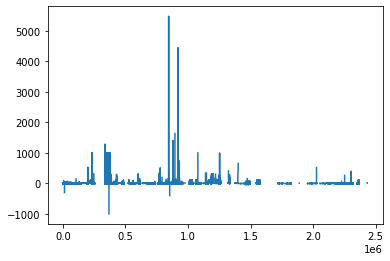

In [23]:
plt.plot(katrina.basefloodelevation)

In [25]:
katrina.basefloodelevation.describe()

count    85716.000000
mean         4.564920
std         37.079796
min       -999.000000
25%         -3.000000
50%          1.000000
75%          9.000000
max       5481.200000
Name: basefloodelevation, dtype: float64

In [26]:
katrina.postfirmconstructionindicator.value_counts().sort_values(ascending=False).head(50)

N    126470
Y     82332
Name: postfirmconstructionindicator, dtype: int64